In [1]:
!pip install -q torch torchvision transformers datasets pillow tqdm

In [2]:
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [3]:
from google.colab import files
import os
import pandas as pd

# Upload captions.csv
uploaded = files.upload()
df = pd.read_csv("captions.csv")

# Upload images
uploaded_imgs = files.upload()
os.makedirs("images", exist_ok=True)
for name in uploaded_imgs.keys():
    with open(f"images/{name}", "wb") as f:
        f.write(uploaded_imgs[name])

Saving captions.csv to captions.csv


Saving captions.csv to captions (1).csv


In [4]:
from PIL import Image
from torch.utils.data import Dataset

class CaptionDataset(Dataset):
    def __init__(self, dataframe, processor, root_dir):
        self.df = dataframe
        self.processor = processor
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(f"{self.root_dir}/{row['image']}").convert("RGB")
        caption = row['caption']

        encoding = self.processor(
            images=image,
            text=caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        return encoding

dataset = CaptionDataset(df, processor, "images")


In [5]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [9]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(2):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Use input_ids as labels for teacher forcing
        outputs = model(
            pixel_values=batch["pixel_values"],
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["input_ids"]
        )

        loss = outputs.loss
        if loss is None:
            continue

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_postfix(loss=loss.item())

Epoch 2: 100%|██████████| 22/22 [00:14<00:00,  1.53it/s, loss=0.218]


In [7]:
import matplotlib.pyplot as plt

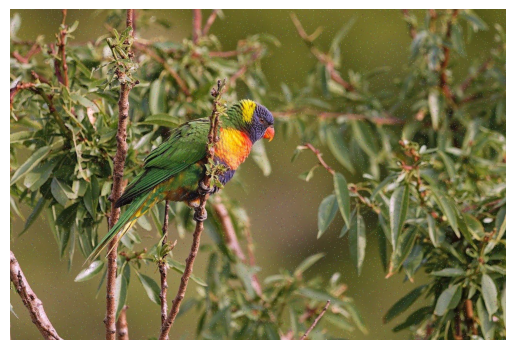

Predicted caption: a bird sitting on brach of a tree


In [19]:
model.eval()
test_image = Image.open("test_images/imageTest1.jpg").convert("RGB")
plt.imshow(test_image)
plt.axis("off")
plt.show()

inputs = processor(images=test_image, return_tensors="pt").to(device)
out = model.generate(**inputs, max_new_tokens=30)
caption = processor.decode(out[0], skip_special_tokens=True)
print("Predicted caption:", caption)
